In [1]:
import numpy as np
import theano
import theano.tensor as T
%matplotlib inline

/Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages/scikits/__init__.py:1: UserWarning: Module IPython was already imported from /Users/lmcintosh/Git/ipython/IPython/__init__.pyc, but /Library/Frameworks/EPD64.framework/Versions/7.3/lib/python2.7/site-packages is being added to sys.path
  __import__('pkg_resources').declare_namespace(__name__)


# generate a problem instance

In [2]:
num_samples = 1000
num_spatial_dims = 25
num_temporal_dims = 10

In [4]:
stim = np.random.randn(num_samples, num_temporal_dims, num_spatial_dims, num_spatial_dims)
w_star = np.random.randn(num_temporal_dims, num_spatial_dims, num_spatial_dims)

# simulate
u = np.tensordot(stim, w_star, axes=3)
rate = np.log(1 + np.exp(0.1*u))
counts= np.random.poisson(rate)

In [5]:
u.shape

(1000,)


# make the model in Theano

In [8]:
# symbolic variable
w = T.dmatrix('w')

# predicted rate
u = T.tensordot(stim, w, ([1,2], [0,1]))
rhat = T.log(1+T.exp(0.1*u))

# cost function and gradient
cost = T.mean(rhat - counts*T.log(rhat)) + 0.001*(w**2).sum()
dcost = T.grad(cost, [w])

# compiled functions
obj = theano.function([w], cost)
obj_grad = theano.function([w], dcost)

WARNING (theano.tensor.blas): The environment variable 'DYLD_FALLBACK_LIBRARY_PATH' does not contain the '/Library/Frameworks/EPD64.framework/Versions/7.3/lib' path in its value. This will make Theano use a slow version of BLAS. Update 'DYLD_FALLBACK_LIBRARY_PATH' to contain the said value, this will disable this warning.


# optimization

## Instead of grad_descent import classifier_trainer

In [15]:
import sys
from os.path import expanduser
sys.path.append(expanduser('~/Git/deepRGC/python/'))

In [16]:
import classifier_trainer
from classifiers.convnet import three_layer_convnet
from classifiers.convnet import init_three_layer_convnet

In [17]:
trainer = classifier_trainer.ClassifierTrainer()

## Make train and val indices

## Train model

In [ ]:
model = init_three_layer_convnet()

finetuned_model, loss_history, train_acc_history, val_acc_history = trainer.train_memmap(stim, rate, train_inds, 
                                                                                         val_inds, model, 
                                                                                         three_layer_convnet)

In [9]:
def grad_descent(obj, grad, x0, eta, numiter):
    
    # initialize
    fval = np.zeros(numiter)
    gradnorm = np.zeros(numiter)
    xk = x0.copy()
    
    # for each iteration
    for k in range(numiter):
        
        # compute objective
        fval[k] = obj(xk)
        
        # compute gradient
        dx = grad(xk)[0]
        
        # store gradient norm
        gradnorm[k] = np.linalg.norm(dx.ravel())
        
        # gradient descent update
        xk -= eta * dx
        
        if (k%1000) == 0:
            print('[%i] obj: %5.4f \t ||dx|| %5.4f' % (k, fval[k], gradnorm[k]))
        
    return xk, fval, gradnorm

In [10]:
x0 = 0.01 * np.random.randn(*w_star.shape)
w_opt, fvals, grads = grad_descent(obj, obj_grad, x0, 0.1, 10000)

[0] obj: 1.0401 	 ||dx|| 0.0584
[1000] obj: 0.8555 	 ||dx|| 0.0295
[2000] obj: 0.8065 	 ||dx|| 0.0157
[3000] obj: 0.7920 	 ||dx|| 0.0088
[4000] obj: 0.7874 	 ||dx|| 0.0050
[5000] obj: 0.7858 	 ||dx|| 0.0029
[6000] obj: 0.7853 	 ||dx|| 0.0017
[7000] obj: 0.7851 	 ||dx|| 0.0010
[8000] obj: 0.7851 	 ||dx|| 0.0006
[9000] obj: 0.7850 	 ||dx|| 0.0004


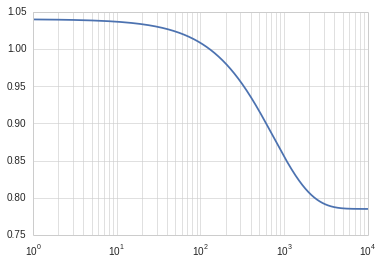

In [11]:
iters = np.arange(fvals.size)
plt.semilogx(iters,fvals)

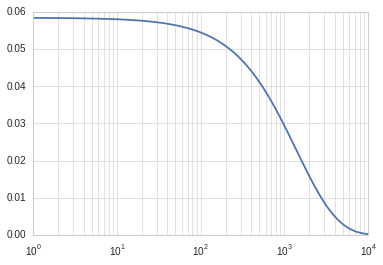

In [12]:
plt.semilogx(iters, grads)

In [14]:
print('Obj at true params: %5.4f\nObj after optimization: %5.4f' % (obj(w_star), fvals[-1]))

Obj at true params: 0.9053
Obj after optimization: 0.7850


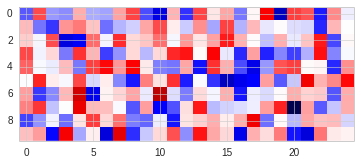

In [15]:
image(w_star)

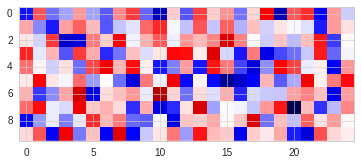

In [16]:
image(w_opt)

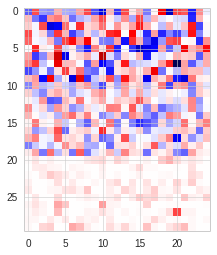

In [17]:
image(np.vstack((w_star,w_opt,0.5*(w_star-w_opt)**2)))